<a href="https://www.kaggle.com/code/samithsachidanandan/merry-xmas-tree-keras-cnn?scriptVersionId=288577201" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Acknowledgements: [https://www.kaggle.com/code/mpwolke/merry-xmas-tree-keras-cnn](https://www.kaggle.com/code/mpwolke/merry-xmas-tree-keras-cnn)

Published on December 25, 2025. By Prata, Marília (mpwolke)

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import plotly.io as pio
pio.renderers.default = 'iframe'

import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

import os

import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam



2025-12-26 17:14:42.448240: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766769282.949757      23 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766769283.082815      23 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766769284.279712      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766769284.279761      23 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766769284.279764      23 computation_placer.cc:177] computation placer alr

In [2]:
# ==================== CONFIGURATION ====================
TRAIN_PATH = "/kaggle/input/hackerearth-holiday-season/dataset/train"
TEST_PATH = "/kaggle/input/hackerearth-holiday-season/dataset/test"
LABELS_CSV = "/kaggle/input/hackerearth-holiday-season/dataset/train.csv"

IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 42

In [3]:
# ==================== LOAD LABELS FROM CSV ====================
print("Loading labels from CSV...")
labels_df = pd.read_csv(LABELS_CSV)
print(f"CSV shape: {labels_df.shape}")
print(f"\nFirst few rows:")
print(labels_df.head())
print(f"\nClass distribution:")
print(labels_df['Class'].value_counts())

# Create a mapping from image filename to class label
image_to_label = dict(zip(labels_df['Image'], labels_df['Class']))

# Encode string labels to integers
label_encoder = LabelEncoder()
labels_df['Class_Encoded'] = label_encoder.fit_transform(labels_df['Class'])
image_to_label_encoded = dict(zip(labels_df['Image'], labels_df['Class_Encoded']))

print(f"\nClass encoding:")
for class_name, class_id in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f"  {class_name} -> {class_id}")

Loading labels from CSV...
CSV shape: (6469, 2)

First few rows:
           Image          Class
0  image3476.jpg  Miscellaneous
1  image5198.jpg         Candle
2  image4183.jpg        Snowman
3  image1806.jpg  Miscellaneous
4  image7831.jpg  Miscellaneous

Class distribution:
Class
Miscellaneous     2801
Christmas_Tree    1539
Jacket             640
Candle             593
Airplane           535
Snowman            361
Name: count, dtype: int64

Class encoding:
  Airplane -> 0
  Candle -> 1
  Christmas_Tree -> 2
  Jacket -> 3
  Miscellaneous -> 4
  Snowman -> 5


In [4]:
#By Mohammed Addoun https://www.kaggle.com/code/mohammedaddoun/trafficsignrecognition/notebook

# ==================== LOAD DATA ====================

def load_images_with_labels(path, img_size, image_label_dict):
    """Load images and assign labels from CSV"""
    images, labels, filenames = [], [], []
    
    if not os.path.exists(path):
        print(f"ERROR: Path does not exist: {path}")
        return np.array([]), np.array([]), []
    
    image_files = [f for f in os.listdir(path) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    
    print(f"\nFound {len(image_files)} images in {path}")
    
    loaded_count = 0
    skipped_count = 0
    
    for img_file in image_files:
        # Check if this image has a label
        if img_file not in image_label_dict:
            skipped_count += 1
            continue
        
        img = cv2.imread(os.path.join(path, img_file))
        if img is None:
            skipped_count += 1
            continue
        
        img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        images.append(img)
        labels.append(image_label_dict[img_file])
        filenames.append(img_file)
        loaded_count += 1
    
    print(f"Successfully loaded: {loaded_count}")
    print(f"Skipped: {skipped_count}")
    
    return np.array(images), np.array(labels), filenames



In [5]:
def load_test_images(test_path, img_size):
    """Load test images (no labels)"""
    images, filenames = [], []
    
    if not os.path.exists(test_path):
        print(f"ERROR: Test path does not exist: {test_path}")
        return np.array([]), []
    
    image_files = [f for f in os.listdir(test_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
    
    print(f"\nFound {len(image_files)} test images")
    
    for img_file in image_files:
        img = cv2.imread(os.path.join(test_path, img_file))
        if img is None:
            continue
            
        img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        filenames.append(img_file)
    
    print(f"Loaded {len(images)} test images")
    return np.array(images), filenames

In [6]:
# ==================== LOAD DATA ====================
# Load training data with labels
print("\n" + "="*50)
print("LOADING TRAINING DATA")
print("="*50)
X_train, y_train, train_filenames = load_images_with_labels(
    TRAIN_PATH, IMAGE_SIZE, image_to_label_encoded
)

# Check if data was loaded
if len(X_train) == 0:
    raise ValueError("No training data found. Cannot proceed.")

# Load test data
print("\n" + "="*50)
print("LOADING TEST DATA")
print("="*50)
X_test, test_filenames = load_test_images(TEST_PATH, IMAGE_SIZE)

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train
)






LOADING TRAINING DATA

Found 6469 images in /kaggle/input/hackerearth-holiday-season/dataset/train
Successfully loaded: 6469
Skipped: 0

LOADING TEST DATA

Found 3489 test images
Loaded 3489 test images


In [7]:
# ==================== SUMMARY ====================
print("\n" + "="*50)
print("DATASET SUMMARY")
print("="*50)
print(f"Training images   : {X_train.shape}")
print(f"Validation images : {X_val.shape}")
print(f"Test images       : {X_test.shape}")
print(f"Number of classes : {len(np.unique(y_train))}")
print(f"Class distribution in training:")
unique, counts = np.unique(y_train, return_counts=True)
for class_id, count in zip(unique, counts):
    class_name = label_encoder.inverse_transform([class_id])[0]
    print(f"  Class {class_id} ({class_name}): {count} images")
print("="*50)


DATASET SUMMARY
Training images   : (5175, 128, 128, 3)
Validation images : (1294, 128, 128, 3)
Test images       : (3489, 128, 128, 3)
Number of classes : 6
Class distribution in training:
  Class 0 (Airplane): 428 images
  Class 1 (Candle): 474 images
  Class 2 (Christmas_Tree): 1231 images
  Class 3 (Jacket): 512 images
  Class 4 (Miscellaneous): 2241 images
  Class 5 (Snowman): 289 images


## CNN model

In [8]:
##By @jocelyndumlao

def create_cnn_model(image_size, num_classes):
    """
    Improved CNN model with better regularization and architecture
    """
    model = models.Sequential([
       
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                     input_shape=(image_size[0], image_size[1], 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
       
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
    
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
     
        layers.GlobalAveragePooling2D(),  
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model



In [9]:
# Determine number of classes
num_classes = len(np.unique(y_train))

# Create the CNN model
model = create_cnn_model(IMAGE_SIZE, num_classes)


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1766769373.587774      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766769373.591605      23 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 685,990 (2.62 MB)

 Trainable params: 683,814 (2.61 MB)

 Non-trainable params: 2,176 (8.50 KB)

In [10]:


# ==================== DATA AUGMENTATION ====================
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator()


train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [11]:


# ==================== TRAINING ====================
EPOCHS = 50

history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(X_val) // BATCH_SIZE,
    verbose=1
)


Epoch 1/50


I0000 00:00:1766769382.191073      67 service.cc:152] XLA service 0x7866e000ae20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766769382.191136      67 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766769382.191141      67 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766769383.399139      67 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-26 17:16:27.663629: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 17:16:27.817511: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 17:16:29.245673: E external/local_xl

  2/161 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.2812 - loss: 2.1686 

I0000 00:00:1766769398.161412      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 80/161 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.3194 - loss: 2.1908

2025-12-26 17:16:50.505174: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 17:16:50.656313: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 17:16:51.730349: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-26 17:16:52.008098: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


161/161 ━━━━━━━━━━━━━━━━━━━━ 55s 207ms/step - accuracy: 0.3476 - loss: 2.0463 - val_accuracy: 0.4344 - val_loss: 2.2497
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4062 - loss: 1.5343 - val_accuracy: 0.4344 - val_loss: 2.3006
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.4922 - loss: 1.4678 - val_accuracy: 0.4344 - val_loss: 2.2441
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5938 - loss: 1.3187 - val_accuracy: 0.4344 - val_loss: 2.2265
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.5341 - loss: 1.3171 - val_accuracy: 0.5203 - val_loss: 1.5100
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6250 - loss: 1.1459 - val_accuracy: 0.5227 - val_loss: 1.5160
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.5531 - loss: 1.2333 - val_accuracy: 0.5508 - val_loss: 1.3047
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5312 - loss: 1.1500 - val_accuracy: 0

## Model Evaluation

In [12]:
# By @jocelyndumlao

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.5842


## Visualization of Training History

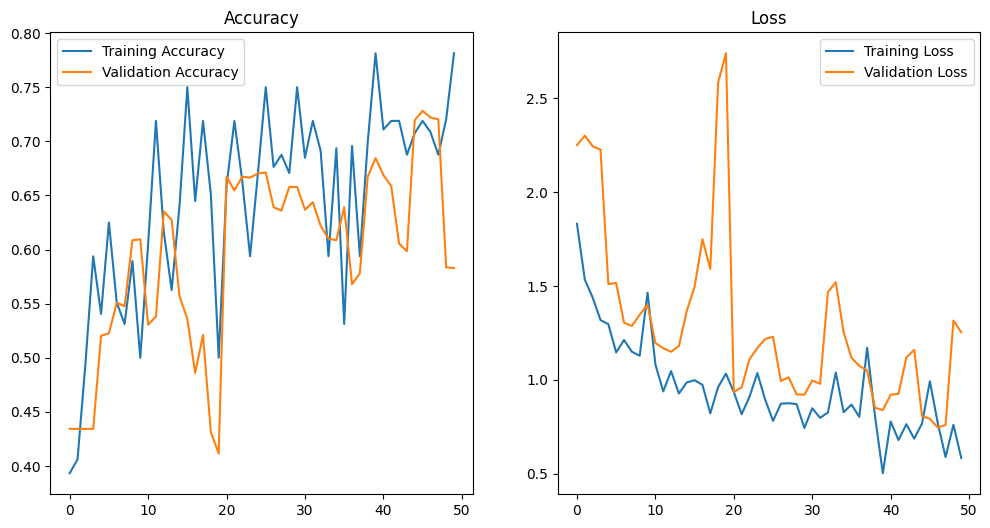

In [13]:
#By @jocelyndumlao



def plot_training_history(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Training Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Training Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()


plot_training_history(history)

## Save Keras model

In [14]:
#By @jocelyndumlao

model.save("patterns_classifier.keras") # Saves the entire model to a HDF5 file
print("Model saved to patterns_classifier.keras")

Model saved to patterns_classifier.keras


## Prediction

In [15]:
#By @jocelyndumlao

# Choose a random image from the validation set
import random 

index = random.randint(0, len(X_val) - 1)
sample_image = X_val[index]
true_label = y_val[index]

In [16]:
#By @jocelyndumlao

# Add a batch dimension to the image (required by the model)
sample_image = np.expand_dims(sample_image, axis=0)

In [17]:
#By @jocelyndumlao

# Make a prediction
prediction = model.predict(sample_image)
predicted_label = 1 if prediction[0][0] > 0.5 else 0  # Threshold at 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


## Display the image and prediction

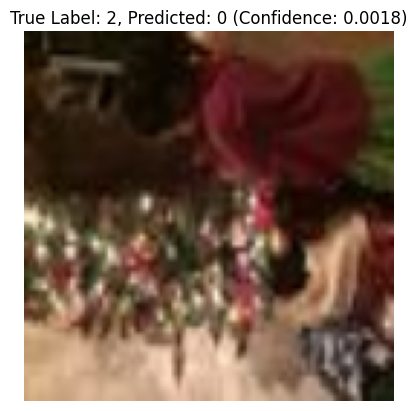

In [18]:
#By @jocelyndumlao

# Display the image and prediction
plt.imshow(X_val[index]) # show the original image instead of the batched one
plt.title(f"True Label: {int(true_label)}, Predicted: {predicted_label} (Confidence: {prediction[0][0]:.4f})")
plt.axis('off')
plt.show()

#Acknowledgements:

NikhilAgrawal https://www.kaggle.com/code/nikhil741/hackerearth-holiday-season-starter-kernel/notebook

Jocelyn Dumlao

Mohammed Addoun https://www.kaggle.com/code/mohammedaddoun/trafficsignrecognition/notebook